# Variational Autoencoders (VAE)

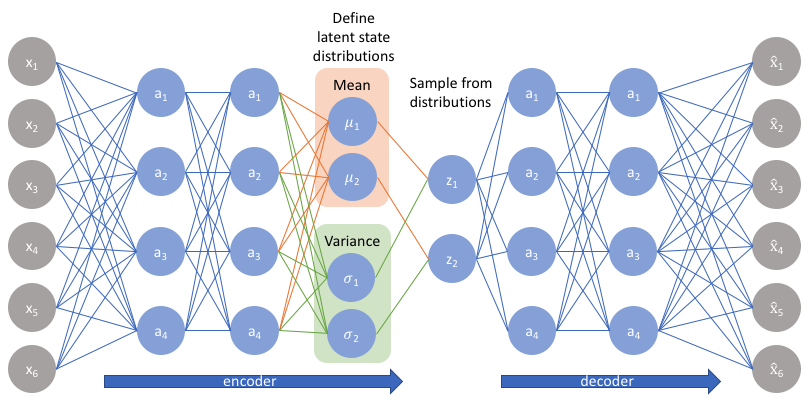

To do:

    - Hyper parameter tuning
    - Include variances

**Note** It only works with numpy<2 then tensorflow has to be <2.18 
!pip install tensorflow==2.17.0

In [ ]:
import tensorflow as tf
import optuna
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import pandas as pd
from scipy.stats import spearmanr, pearsonr, chi2_contingency, normaltest, mstats
from sklearn.metrics import mutual_info_score
import warnings
from utils.utils import plot_probobability_distributions
warnings.filterwarnings("ignore")

## The Data

In [3]:
cluster_name = "influencers"
df = pd.read_csv(f"temp/{cluster_name}_atributes.csv")
display(df)

df = df.drop("user_id", axis=1)

,user_id,Followers (Millions),Following,QRT,RT,tweet,topic_probs_arts_&_culture,topic_probs_business_&_entrepreneurs,topic_probs_celebrity_&_pop_culture,topic_probs_diaries_&_daily_life,...,topic_probs_news_&_social_concern,topic_probs_other_hobbies,topic_probs_relationships,topic_probs_science_&_technology,topic_probs_sports,topic_probs_travel_&_adventure,topic_probs_youth_&_student_life,sentiment_probs_negative,sentiment_probs_neutral,sentiment_probs_positive
0,100220864,43.2,95,23,0,41,0.01190,0.04286,0.35286,0.22143,...,0.07143,0.00952,0.04190,0.00000,0.10143,0.00000,0.00000,0.24381,0.25143,0.43333
1,101311381,42.3,77,3,0,57,0.06906,0.01500,0.15750,0.39250,...,0.11656,0.06469,0.13469,0.00000,0.15031,0.00000,0.00000,0.07938,0.07344,0.78969
2,10228272,74.9,1204,0,0,111,0.01404,0.00489,0.19532,0.29043,...,0.08404,0.03000,0.03000,0.02191,0.00000,0.00000,0.01894,0.01213,0.53064,0.36681
3,10671602,24.3,753,0,0,260,0.01819,0.03048,0.00699,0.02735,...,0.06229,0.02880,0.00000,0.05892,0.14530,0.00289,0.00265,0.03506,0.48386,0.43265
4,113419517,32.0,89,0,0,41,0.21182,0.00000,0.18091,0.34727,...,0.00000,0.11636,0.14364,0.00000,0.00000,0.00000,0.00000,0.07364,0.14000,0.74364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,813286,131.2,586242,8,0,945,0.04643,0.04514,0.03357,0.09014,...,0.80714,0.00000,0.04129,0.07771,0.01400,0.00814,0.00386,0.09457,0.28229,0.55071
69,84279963,36.0,3476,108,0,5698,0.00811,0.00781,0.25757,0.24870,...,0.01521,0.01757,0.05296,0.00000,0.04426,0.00000,0.00000,0.06231,0.21941,0.65675
70,85603854,45.3,1853,4,0,35,0.04923,0.00000,0.18538,0.22538,...,0.01538,0.04000,0.04923,0.00000,0.07154,0.02000,0.00000,0.05923,0.41308,0.46231
71,939091,33.1,48,4,0,1370,0.00000,0.14410,0.00000,0.03630,...,0.93970,0.00000,0.00000,0.02760,0.00890,0.00000,0.01200,0.24500,0.29700,0.36770


1. Visualize distributions of each column


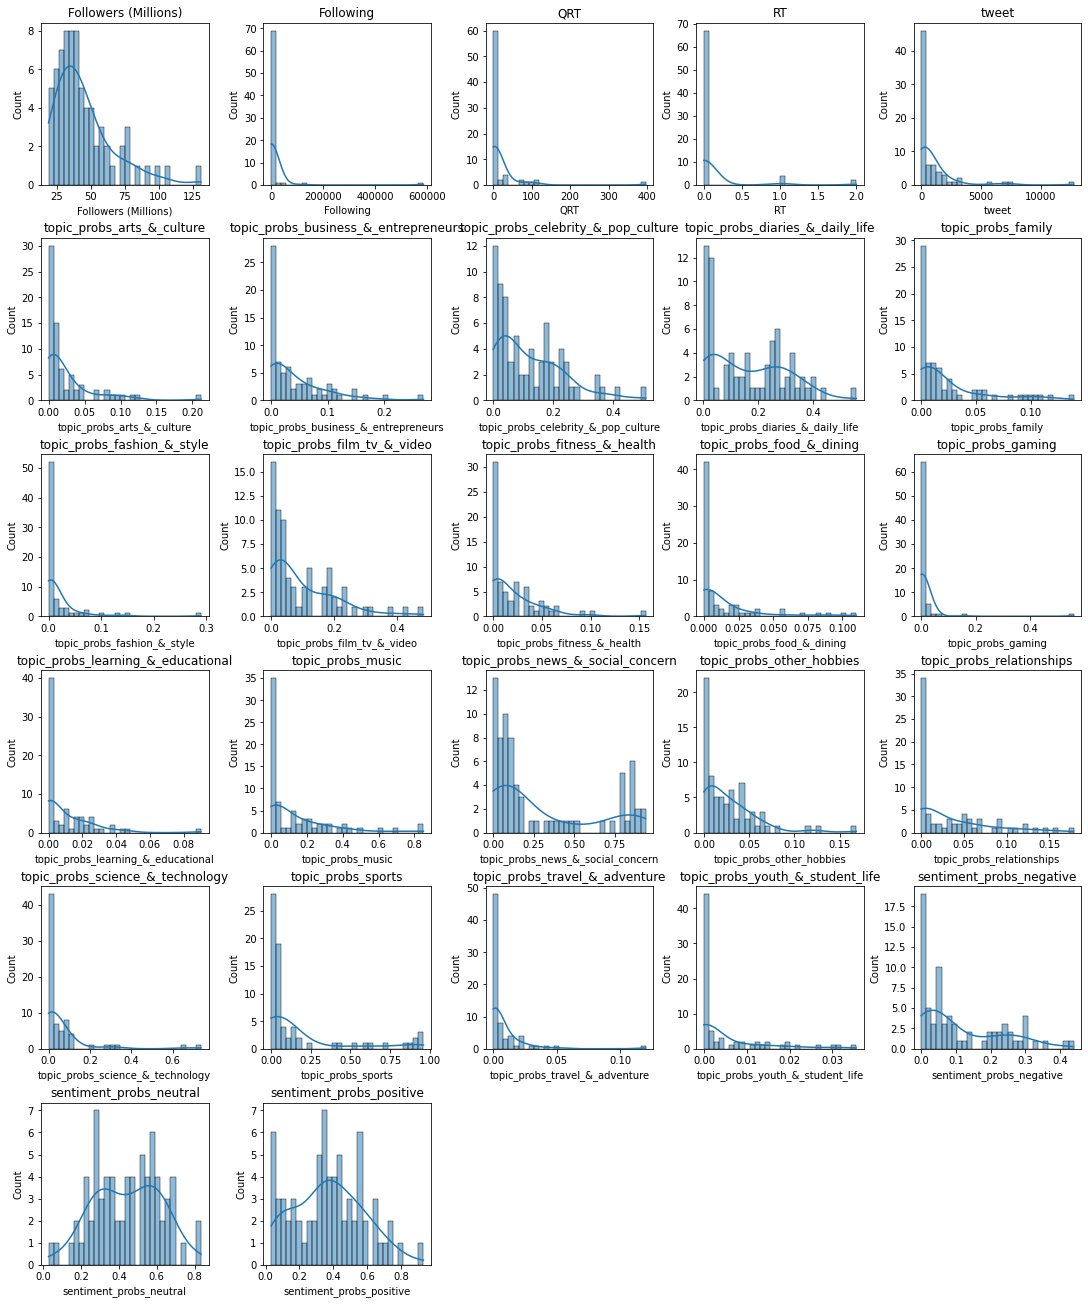

In [4]:
print("1. Visualize distributions of each column")
        
def plot_distributions(df):
    num_cols = 5  # Number of plots per row
    num_rows = (len(df.columns) + num_cols - 1) // num_cols  # Calculate required rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    axes = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f"{col}")
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
plot_distributions(df)


2. Check pairwise correlations


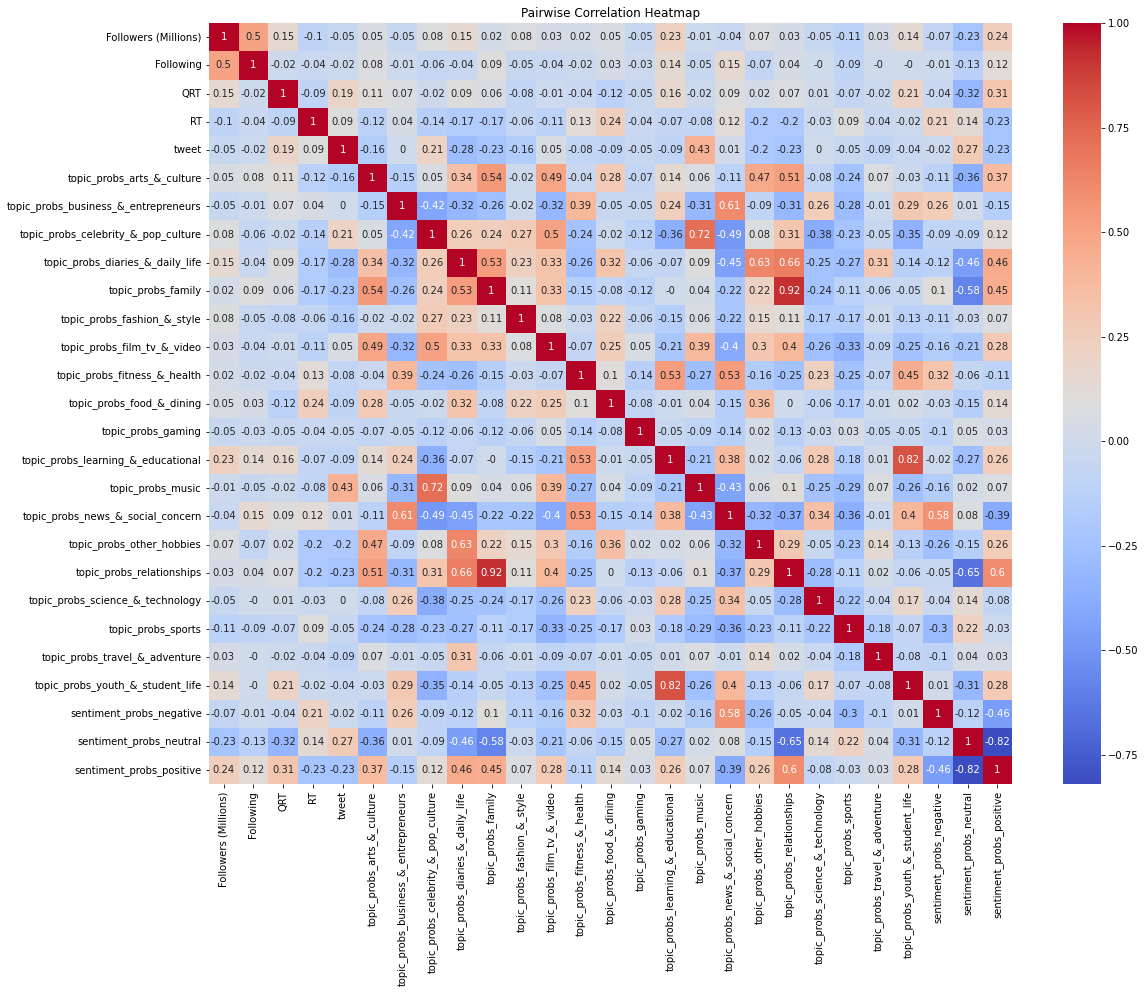

In [5]:
print("\n2. Check pairwise correlations")
def compute_correlations(df):
    plt.figure(figsize=(18, 14))
    corr_matrix = df.corr(method='pearson')
    corr_matrix = round(corr_matrix, 2)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title("Pairwise Correlation Heatmap")
    plt.show()

compute_correlations(df)

## The Model

In [6]:
class VAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim, reconstruction_param, encoder_units, decoder_units, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder(input_dim, latent_dim, encoder_units)
        self.decoder = self.build_decoder(input_dim, latent_dim, decoder_units)
        self.reconstruction_param = reconstruction_param

    def build_encoder(self, input_dim, latent_dim, units):
        encoder_inputs = tf.keras.Input(shape=(input_dim,))
        x = layers.Dense(units, activation='relu', kernel_initializer='he_normal')(encoder_inputs)
        x = layers.Dense(units, activation='relu')(x)
        z_mean = layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
        return tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
    
    def build_decoder(self, input_dim, latent_dim, units):
        latent_inputs = tf.keras.Input(shape=(latent_dim,))
        x = layers.Dense(units, activation='relu')(latent_inputs)
        x = layers.Dense(units, activation='relu')(x)
        decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)
        return tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling((z_mean, z_log_var))
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= data.shape[1]
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -tf.reduce_mean(kl_loss)
            
            total_loss = (
                self.reconstruction_param * reconstruction_loss +
                (1 - self.reconstruction_param) * kl_loss
            )
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def reconstruct_agents(self, agent_data):
        z_mean, z_log_var = self.encoder(agent_data)
        z = self.sampling((z_mean, z_log_var))
        reconstruction = self.decoder(z)
        return reconstruction
    
    def generate_new_agents(self, num_samples):
        latent_samples = tf.random.normal(shape=(num_samples, self.latent_dim))
        generated_vectors = self.decoder(latent_samples)
        return generated_vectors

## The implementation

#### Separate Train-Test

In [7]:
# Load and preprocess the data
input_dim = len(df.columns)

data = pd.read_csv(f'temp/{cluster_name}_atributes.csv')
data.drop('user_id', axis=1, inplace=True)

data = data.to_numpy(dtype=np.float32)
log_data = np.log1p(data + 1e-10)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(log_data)

input_dim = normalized_data.shape[1]

# Split the data once (outside the objective function)
train_data, test_data = train_test_split(normalized_data, test_size=0.2, random_state=42)
train_data = tf.convert_to_tensor(train_data, dtype=tf.float32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)

### Training the model

#### Set global parameters

In [8]:
reconstruction_param = 0.9

#### Hyperparameter tunning with Optuna

In [ ]:
def objective(trial, train_data):
    # Hyperparameter search space
    hyperparameters = {
        'latent_dim': trial.suggest_int("latent_dim", 2, 6),
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
        'encoder_units': trial.suggest_categorical("encoder_units", [32, 64, 128, 256]),
    }
    
    # Instantiate the model with sampled hyperparameters
    model = VAE(
        input_dim=input_dim,
        latent_dim=hyperparameters['latent_dim'],
        reconstruction_param=reconstruction_param,
        encoder_units=hyperparameters['encoder_units'],
        decoder_units=hyperparameters['encoder_units']  # Symmetrical
    )
    
    model.compile(optimizer=optimizers.Adam(learning_rate=hyperparameters["learning_rate"]))
    
    history = model.fit(
        train_data,
        epochs=1000,
        batch_size=hyperparameters['batch_size'],
        verbose=0
    )
    
    # Function to evaluate the loss curve
    def evaluate_loss_curve(loss_curve):
        smoothness_penalty = np.sum(np.abs(np.diff(loss_curve)))  # Penalize abrupt changes
        final_loss = loss_curve[-1]  # Final loss
        mean_loss = np.mean(loss_curve)  # Mean loss across all epochs
        score = final_loss + 0.1 * smoothness_penalty
        return score

    # Get validation loss for evaluation
    score = evaluate_loss_curve(history.history['loss'])
    
    return score

# Run the Optuna study with pre-split data
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train_data), n_trials=30)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

#### Train with the best trial

In [9]:
#best_hyperparams = study.best_params
best_hyperparams = {'latent_dim': 5, 'learning_rate': 0.01, 'batch_size': 256, 'encoder_units': 64, 'batch_size': 128}

model = VAE(
    input_dim=input_dim,
    latent_dim=best_hyperparams['latent_dim'],
    reconstruction_param=reconstruction_param,
    encoder_units=best_hyperparams['encoder_units'],
    decoder_units=best_hyperparams['encoder_units']  # Symmetrical
)

model.compile(optimizer=optimizers.Adam(learning_rate=best_hyperparams["learning_rate"]))

history = model.fit(
    train_data,
    epochs=1000,
    batch_size=best_hyperparams['batch_size'],
    verbose=0
)

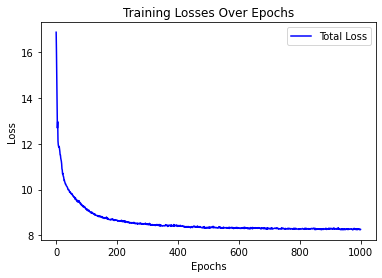

In [10]:
# Plot the losses after training
plt.plot(history.history['loss'],'b', label="Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses Over Epochs")
plt.show()

### Validate Reconstruction

Original test sample:
 [[0.27 0.34 0.   0.   0.21 1.   0.   0.4  0.67 0.58 0.   1.   0.   0.77
  0.   0.   0.2  0.   0.71 0.82 0.   0.   0.   0.   0.2  0.18 0.84]
 [0.32 0.22 0.12 0.   0.61 0.02 0.2  0.17 0.05 0.1  0.02 0.09 0.27 0.03
  0.01 0.04 0.02 0.93 0.02 0.03 0.15 0.07 0.01 0.05 0.64 0.78 0.03]
 [0.85 0.31 0.   0.   0.59 0.   0.27 0.06 0.6  0.21 0.   0.   0.   0.24
  0.05 0.29 0.02 0.09 0.45 0.33 0.01 0.55 0.   0.63 0.02 0.37 0.75]]
Reconstructed test sample:
 [[0.31 0.14 0.06 0.   0.21 0.8  0.13 0.34 0.74 0.82 0.02 0.82 0.09 0.12
  0.   0.   0.08 0.11 0.34 0.79 0.02 0.14 0.02 0.   0.01 0.31 0.82]
 [0.5  0.3  0.   0.   0.56 0.02 0.31 0.2  0.02 0.07 0.02 0.07 0.27 0.02
  0.   0.01 0.04 0.93 0.01 0.01 0.13 0.11 0.01 0.05 0.51 0.8  0.06]
 [0.63 0.49 0.58 0.   0.58 0.24 0.33 0.09 0.5  0.27 0.05 0.14 0.29 0.19
  0.   0.22 0.01 0.31 0.19 0.27 0.1  0.45 0.15 0.39 0.05 0.33 0.8 ]]


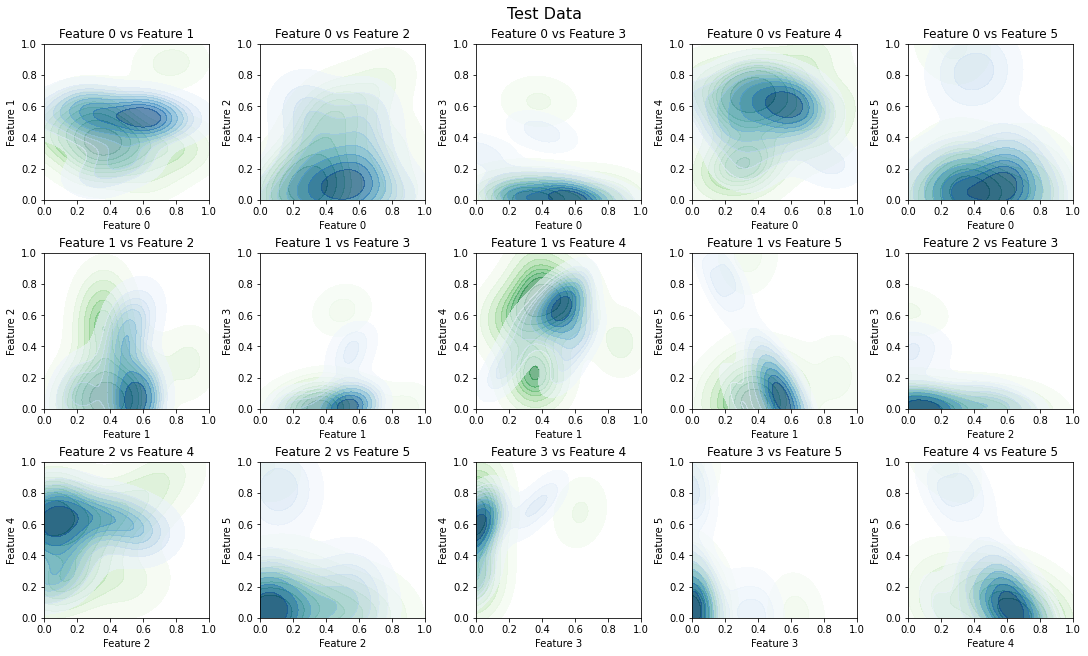

In [11]:
test_reconstructed = model.reconstruct_agents(test_data)

# Display original and reconstructed samples for comparison
print("Original test sample:\n", np.round(test_data[:3], 2))
print("Reconstructed test sample:\n", np.round(test_reconstructed[:3], 2))

# Plot a subset of the probability distributions
plot_probobability_distributions("Test Data", test_data[:, :6], test_reconstructed[:, :6])

### Generate New Agents

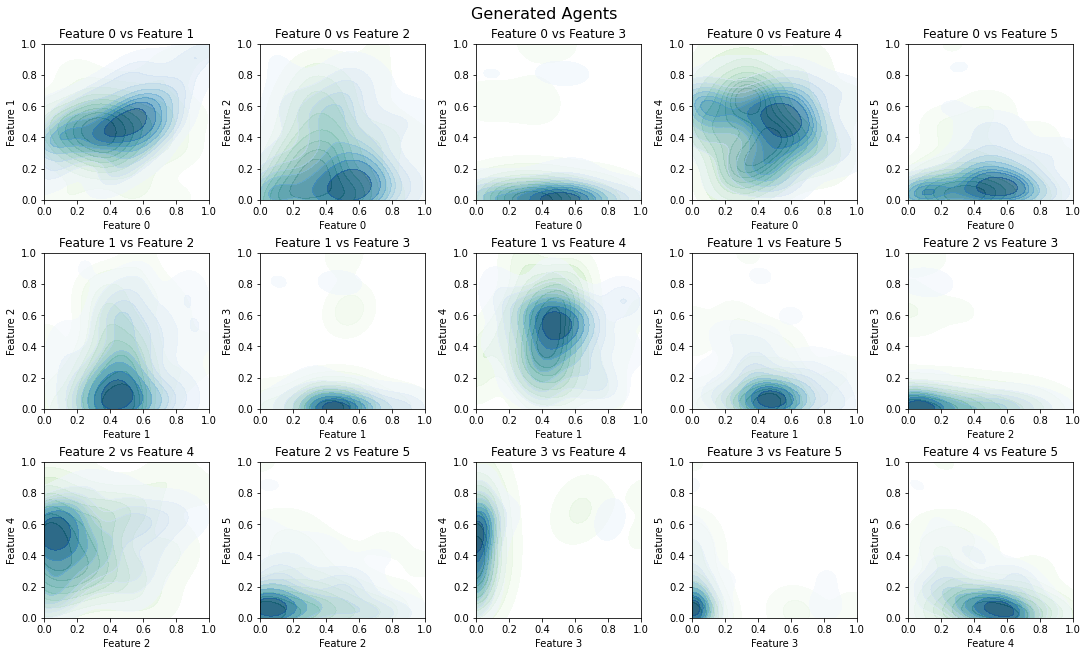

In [14]:
new_agents = model.generate_new_agents(num_samples=80)
plot_probobability_distributions("Generated Agents", normalized_data[:, :6], new_agents[:, :6])